# Final Project
##### Juntang Wang (jw853)

---

In this project, we want to understand the limitations of geometric Brownian motion under both physical and risk-neutral
measures.

- Under the physical measure, show that the geometric Brownian motion do not work well during the market crash by
conducting the hypothesis testing from 4/25/2024 to 4/25/2025. (Similar to HW5)

- I’ve included a sample of real market option data in 2011. Calculate the mean-squared error using Black-Scholes-Merton
and fix an expiration date to get a volatility smirk pattern. You may assume the volatility σ on that date is 0.17.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

### Part 1: “Physical” GBM under market crash (4 / 25 / 2024 – 4 / 25 / 2025)

We’ll replicate HW5’s KS-test but now over the “crash” year, and use a parametric bootstrap to get a more accurate p-value.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, norm
import yfinance as yf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook"])

# Download S&P 500 from 2024-04-25 to 2025-04-25
df = yf.download('^GSPC',
                 start='2024-04-25',
                 end  ='2025-04-25',
                 progress=False)
display(df.head())

# daily log-returns
rets = np.log(df['Close'] / df['Close'].shift(1)).dropna()
N    = len(rets)

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2024-04-25,5048.419922,5057.750000,4990.580078,5019.879883,3958050000
2024-04-26,5099.959961,5114.620117,5073.140137,5084.649902,3604140000
2024-04-29,5116.169922,5123.490234,5088.649902,5114.129883,3447450000
2024-04-30,5035.689941,5110.830078,5035.310059,5103.779785,4082470000
2024-05-01,5018.390137,5096.120117,5013.450195,5029.029785,4544170000


  0%|          | 0/5000 [00:00<?, ?it/s]

   Observed p-value = 0.0004     (not valid, print just for fun)
Monte Carlo p-value = 0.0002


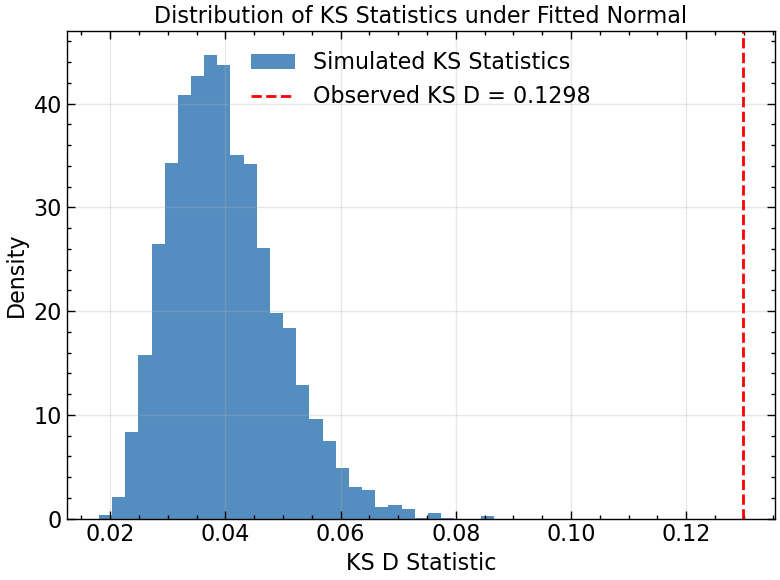

In [3]:
# Estimate parameters from observed returns
mu_hat, sigma_hat = rets.mean(), rets.std(ddof=1)

# Observed KS test
ks_obs = kstest(
    rets, lambda x: norm.cdf(x, loc=mu_hat, scale=sigma_hat)
)
D_obs, p_obs = ks_obs.statistic, ks_obs.pvalue

# Parametric bootstrap
M = 5000
D_sim = np.empty(M)

for i in tqdm(range(M)):
    # Generate sample and compute KS statistic
    sample = np.random.normal(mu_hat, sigma_hat, size=N)
    mu_i, sigma_i = sample.mean(), sample.std(ddof=1)
    D_sim[i] = kstest(
        sample, lambda x: norm.cdf(x, loc=mu_i, scale=sigma_i)
    ).statistic

print(f"   Observed p-value = {p_obs[0]:.4f} \
    (not valid, print just for fun)")
# Calculate Monte Carlo p-value
p_MC = (1 + np.sum(D_sim >= D_obs)) / (M + 1)
print(f"Monte Carlo p-value = {p_MC:.4f}")

# Visualization
plt.figure()
plt.hist(D_sim, bins=30, alpha=0.7, density=True, 
         label='Simulated KS Statistics')
plt.axvline(D_obs, color='red', linestyle='--', linewidth=2, 
            label=f'Observed KS D = {D_obs[0]:.4f}')
plt.xlabel('KS D Statistic')
plt.ylabel('Density')
plt.title('Distribution of KS Statistics under Fitted Normal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Null hypothesis ($H_0$):
    The daily log‐returns $r_t$ over 4/25/2024–4/25/2025 come from a drifted Brownian motion, i.e.
    $$
    r_t \;\overset{\text{i.i.d.}}{\sim}\;\mathcal{N}(\mu, \sigma^2)
    $$
    for some constants $\mu,\sigma$.

- We found $p_{\rm MC}\approx0.0002$, which is far below 0.05.
- Therefore: we reject the null hypothesis at the 5% level.
- Interpretation: even after accounting for parameter estimation, the extreme moves during the 2024–2025 crash make the log‐returns incompatible with a simple drifted Brownian‐motion model.

## Part 2 Option-data MSE & volatility smirk (2011 sample)

In [4]:
from scipy.optimize import brentq
# 1) Load the data
df = pd.read_csv('data/data.csv',
                 names=['K','S','T','r','MarketPrice'],
                 skiprows=1)

In [5]:
# 2) BSM call‐pricing function
def bsm_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# 3) Compute model prices with fixed σ = 0.17, then MSE
sigma_fixed = 0.17
df['ModelPrice'] = df.apply(
    lambda row: bsm_call_price(row['S'],
                               row['K'],
                               row['T'],
                               row['r'],
                               sigma_fixed),
    axis=1
)
mse_all = np.mean((df['ModelPrice'] - df['MarketPrice'])**2)
print(f"MSE over all expirations (σ={sigma_fixed}): {mse_all:.4f}")

for T, group in df.groupby('T'):
    mse_T = np.mean((group['ModelPrice'] - group['MarketPrice'])**2)
    print(f"T={T:.4f}  MSE={mse_T:.3f}  (RMSE≈{np.sqrt(mse_T):.2f})")

MSE over all expirations (σ=0.17): 25.5198
T=0.0466  MSE=20.887  (RMSE≈4.57)
T=0.1233  MSE=29.995  (RMSE≈5.48)
T=0.2000  MSE=35.895  (RMSE≈5.99)
T=0.2767  MSE=29.586  (RMSE≈5.44)
T=0.4493  MSE=11.494  (RMSE≈3.39)
T=0.6986  MSE=7.462  (RMSE≈2.73)
T=0.9479  MSE=4.649  (RMSE≈2.16)


In [6]:
# 4) Implied vol: invert BSM to match MarketPrice
def implied_vol(MktP, S, K, T, r):
    # intrinsic‐floor to avoid root failure
    if MktP <= max(S - K*np.exp(-r*T), 0.0):
        return 0.0
    f = lambda vol: bsm_call_price(S, K, T, r, vol) - MktP
    return brentq(f, 1e-6, 5.0)


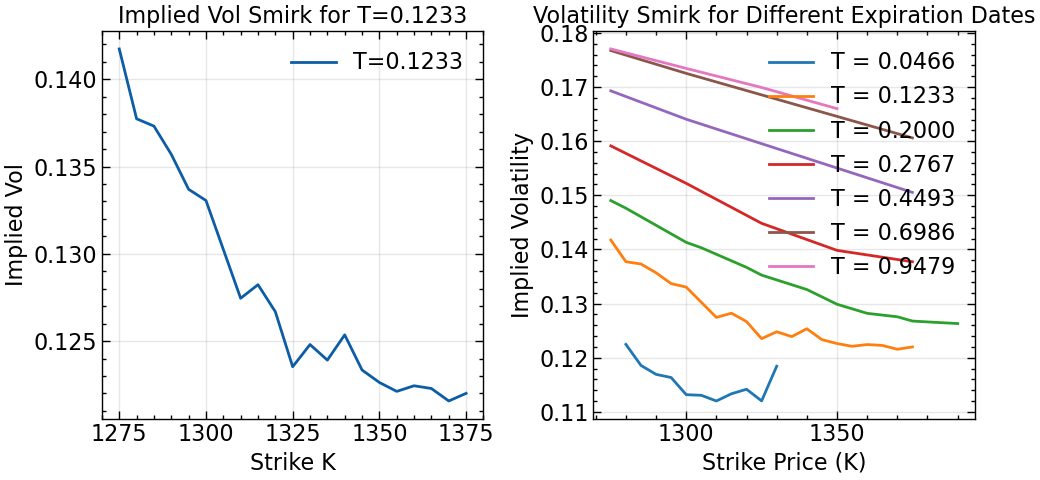

In [7]:

_, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

ax = axes[0]
T0 = 0.123290
smirk = df[df['T']==T0].copy()
smirk['ImpVol'] = smirk.apply(
    lambda r: implied_vol(
        r['MarketPrice'], 
        r['S'], 
        r['K'], 
        r['T'], 
        r['r']), axis=1
)
ax.plot(smirk['K'], smirk['ImpVol'], label=f'T={T0:.4f}')
ax.set_title(f'Implied Vol Smirk for T={T0:.4f}')
ax.set_xlabel('Strike K')
ax.set_ylabel('Implied Vol')
ax.grid(alpha=0.3)
ax.legend()

ax = axes[1]
colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, T0 in enumerate(sorted(df['T'].unique())):
    df_smirk = df[df['T'] == T0].copy()
    df_smirk['ImpVol'] = [implied_vol(row['MarketPrice'], 
                                    row['S'], 
                                    row['K'], 
                                    row['T'], 
                                    row['r']) 
                        for _, row in df_smirk.iterrows()]

    df_smirk = df_smirk.sort_values('K')
    ax.plot(df_smirk['K'], df_smirk['ImpVol'], 
             color=colors[i % len(colors)], 
             label=f'T = {T0:.4f}')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Implied Volatility')
ax.set_title('Volatility Smirk for Different Expiration Dates')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()